In [10]:
import os
import random
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

from tensorflow.math import log, reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

!pip install patchify
from patchify import patchify

import matplotlib.patches as mpatches

In [11]:
root_directory = r"C:\Users\AMAR9XD\OneDrive\Desktop\prachi\pythonProject\Semantic segmentation dataset"

patch_size = 256

In [12]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+'/'+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [13]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [14]:
image_dataset = np.array(image_dataset[:400])
mask_dataset =  np.array(mask_dataset[:400])

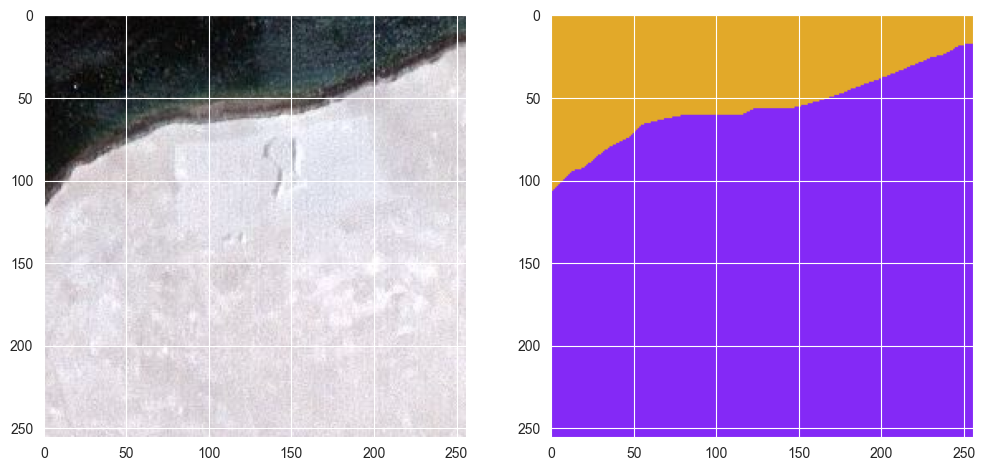

In [15]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [16]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [21]:
label = single_patch_mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 0
    label_seg [np.all(label == Road, axis = -1)] = 1  
    label_seg [np.all(label == Vegetation, axis = -1)] = 0   
    label_seg [np.all(label == Water, axis = -1)] = 0
    label_seg [np.all(label == Building, axis = -1)] = 2
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [22]:
labels = np.array(labels)
labels.shape

(400, 256, 256)

In [23]:
labels_cat = to_categorical(labels)
labels_cat.shape


(400, 256, 256, 3)

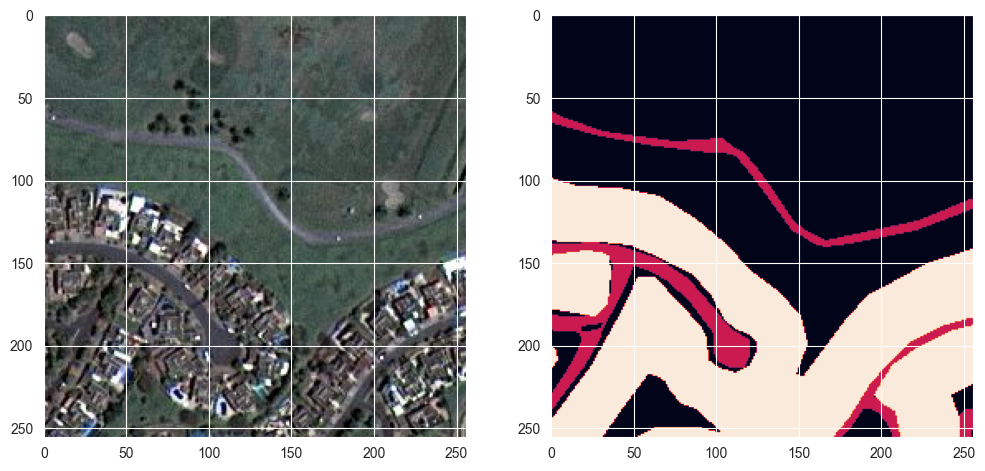

In [24]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number], vmin=0, vmax=2)
plt.show()

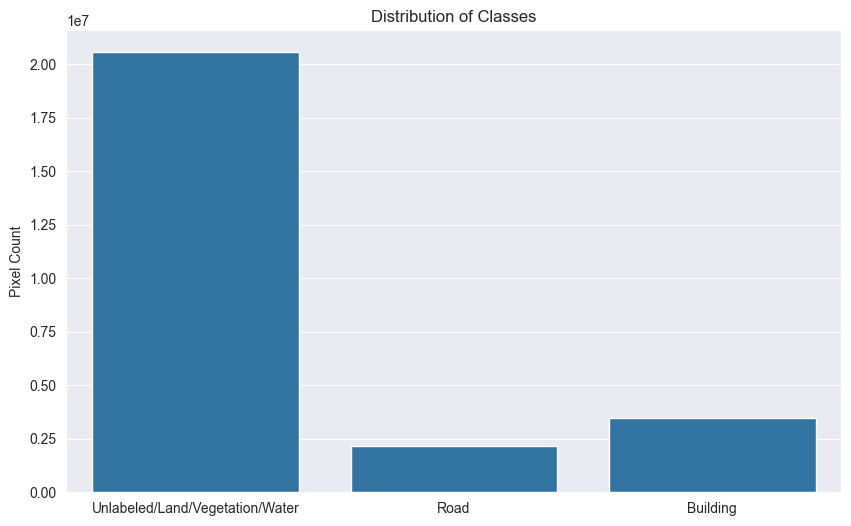

In [25]:
# E D A


import seaborn as sns
from sklearn.utils import shuffle

# 1. Distribution of classes
class_counts = np.sum(labels_cat, axis=(0,1,2))
plt.figure(figsize=(10, 6))
sns.barplot(x=['Unlabeled/Land/Vegetation/Water', 'Road', 'Building'], y=class_counts)
plt.title('Distribution of Classes')
plt.ylabel('Pixel Count')
plt.show()

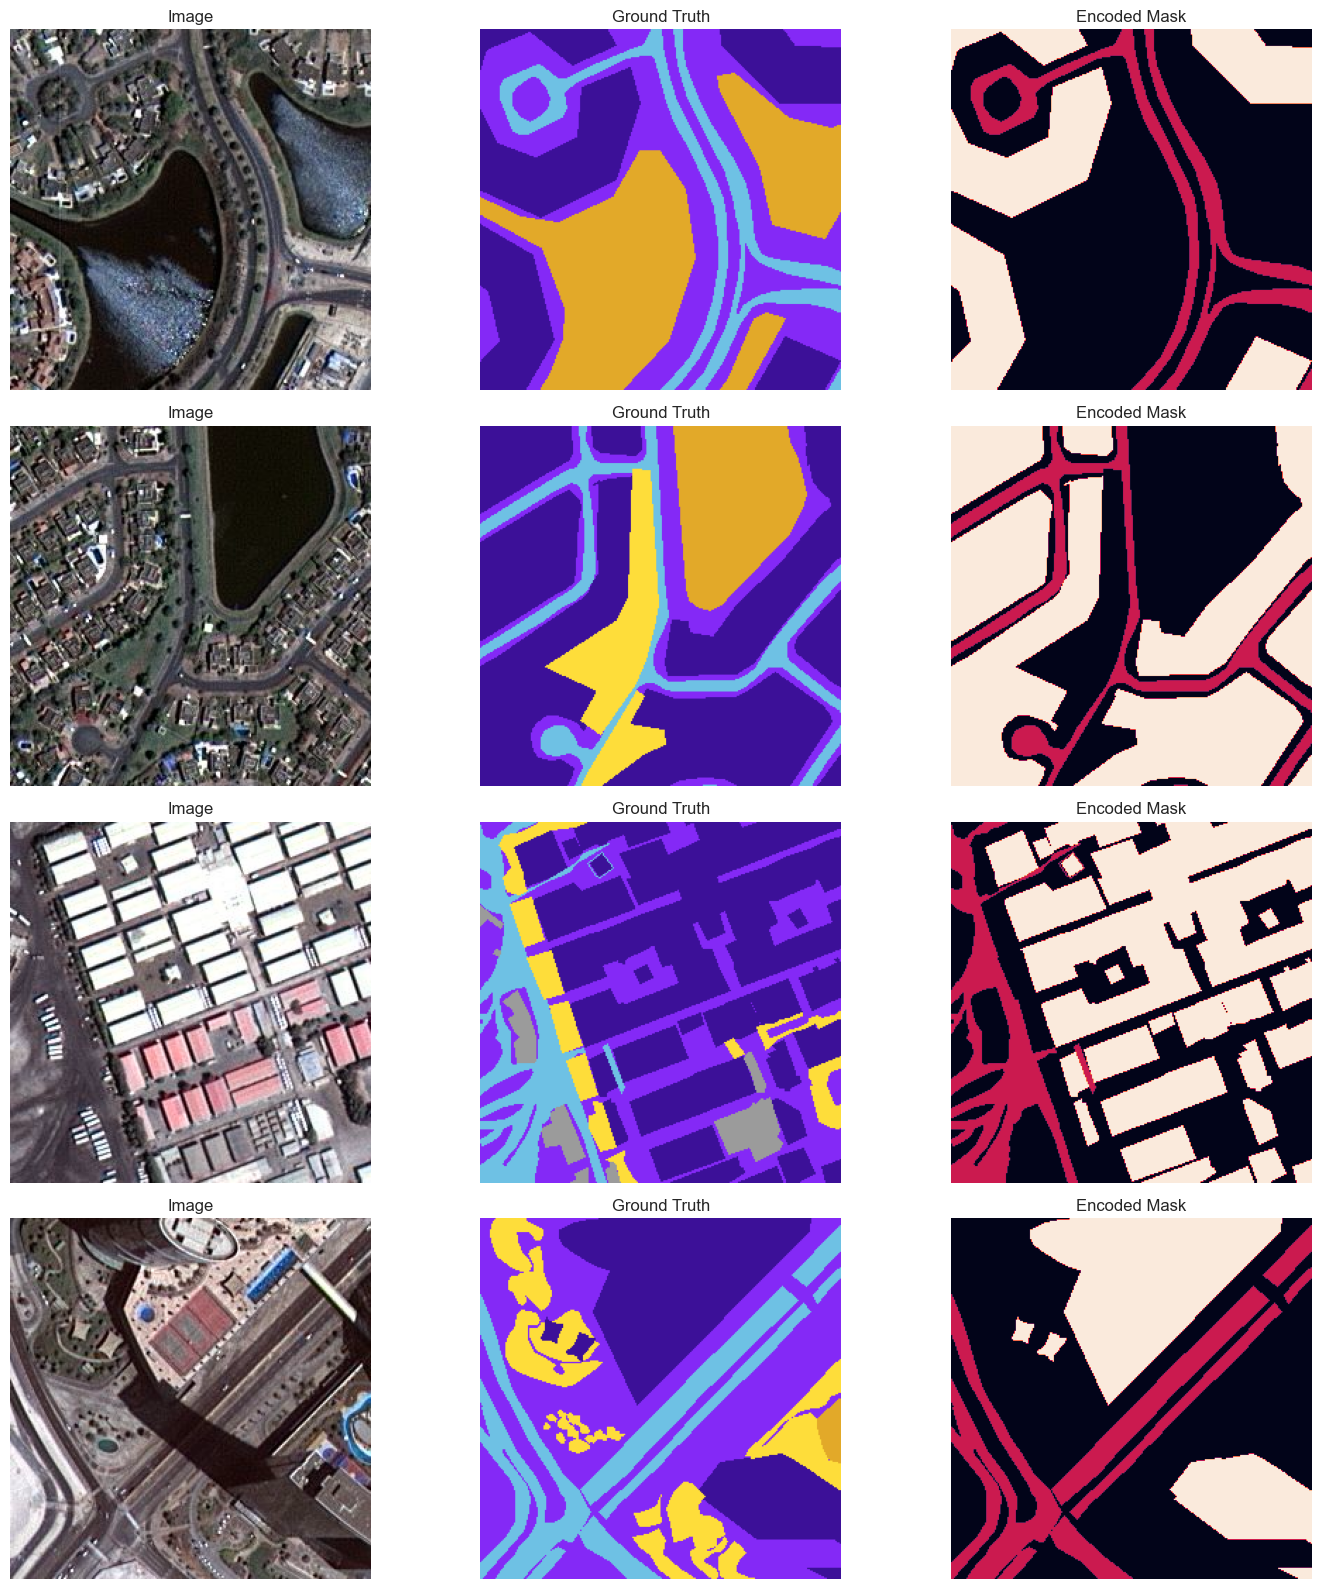

In [26]:
# 2. Sample images with masks
def display_sample(image, mask, num=4):
    plt.figure(figsize=(15, 4*num))
    for i in range(num):
        idx = random.randint(0, len(image_dataset)-1)
        plt.subplot(num, 3, i*3+1)
        plt.imshow(image[idx])
        plt.title('Image')
        plt.axis('off')
        plt.subplot(num, 3, i*3+2)
        plt.imshow(mask[idx])
        plt.title('Ground Truth')
        plt.axis('off')
        plt.subplot(num, 3, i*3+3)
        plt.imshow(labels[idx], vmin=0, vmax=2)
        plt.title('Encoded Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample(image_dataset, mask_dataset)

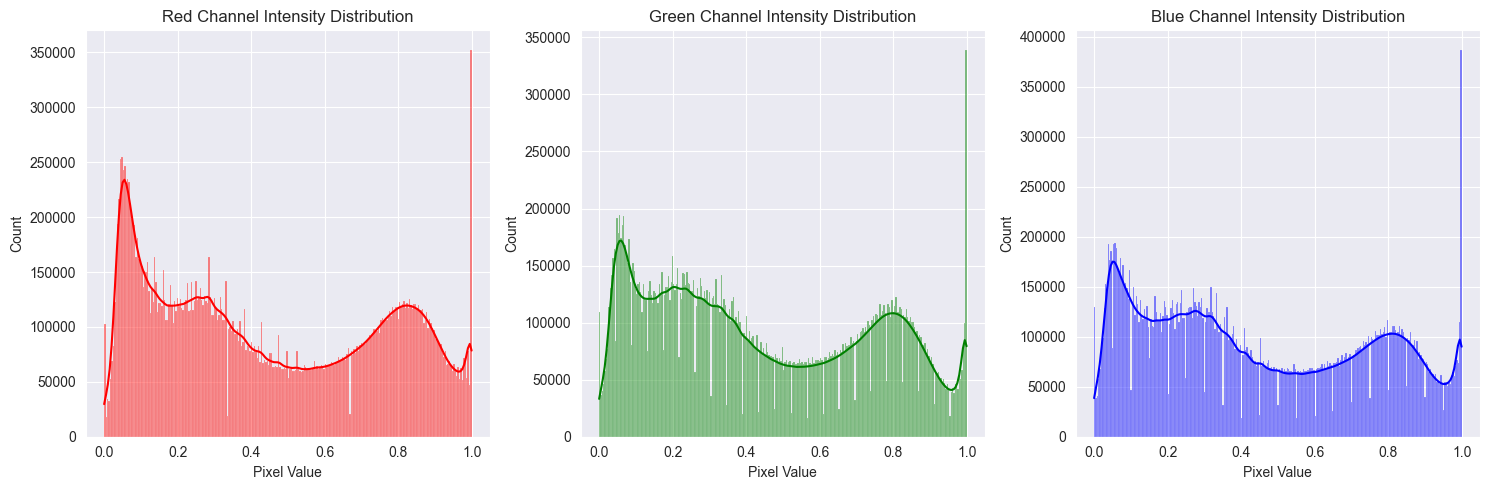

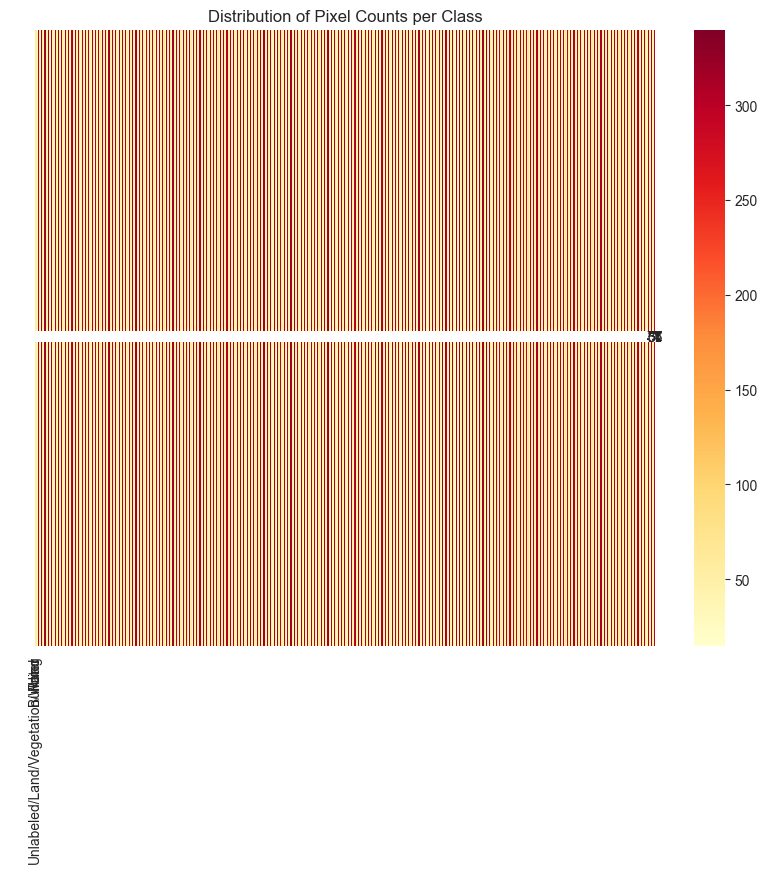

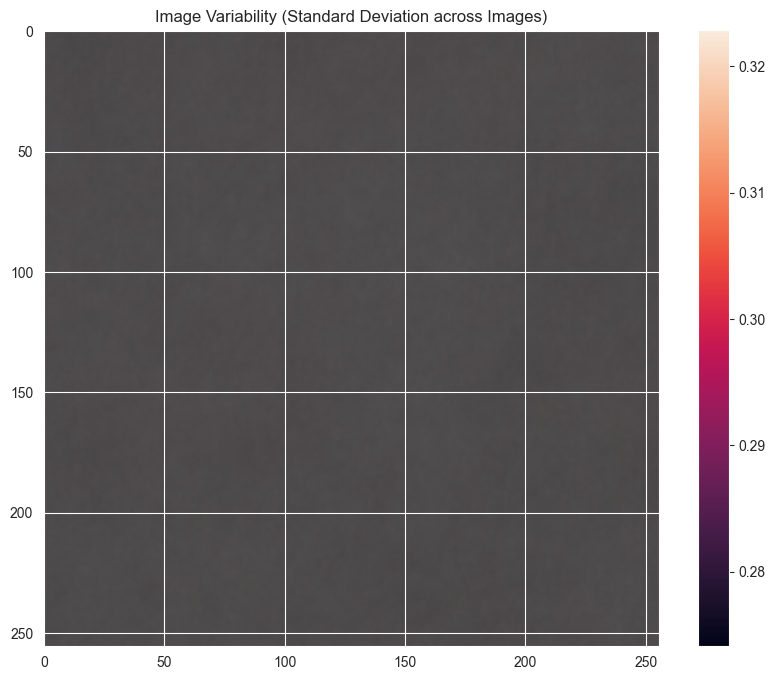

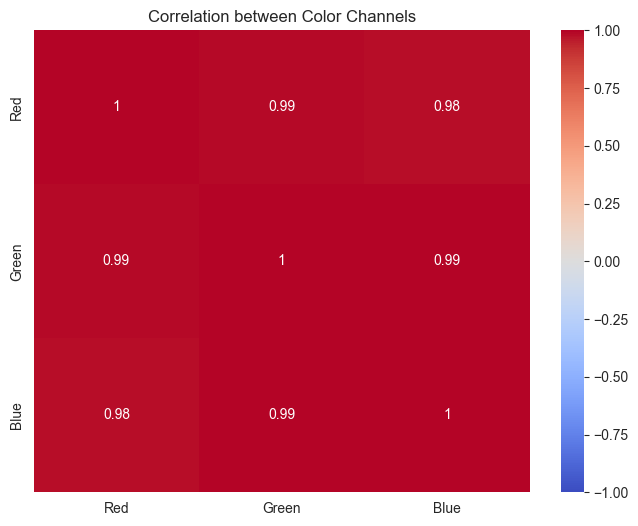

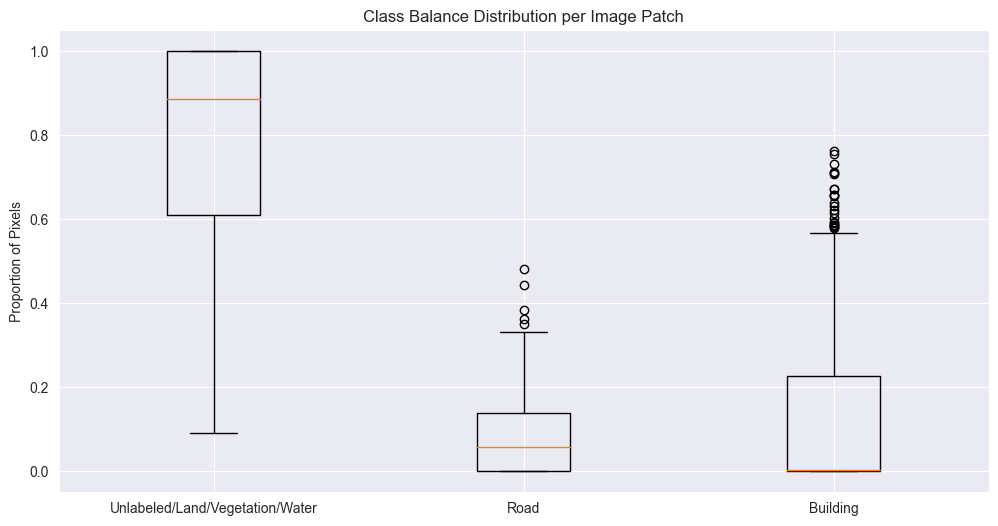

error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x071a8476::Set<1,-1,-1>,struct cv::impl::A0x071a8476::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Pixel Intensity Distribution
plt.figure(figsize=(15, 5))
for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    sns.histplot(image_dataset[:,:,:,i].ravel(), kde=True, color=color)
    plt.title(f'{color.capitalize()} Channel Intensity Distribution')
    plt.xlabel('Pixel Value')
plt.tight_layout()
plt.show()

# 4. Class Distribution Heatmap  
class_heatmap = np.sum(labels_cat, axis=0)
plt.figure(figsize=(10, 8))
sns.heatmap(class_heatmap.reshape(1, -1), cmap='YlOrRd', annot=True, cbar=True,
            xticklabels=['Unlabeled/Land/Vegetation/Water', 'Road', 'Building'])
plt.title('Distribution of Pixel Counts per Class')
plt.yticks([])
plt.show()

# 5. Image Variability
def image_variability(images):
    return np.std(images, axis=0)

variability = image_variability(image_dataset)
plt.figure(figsize=(10, 8))
plt.imshow(variability)
plt.colorbar()
plt.title('Image Variability (Standard Deviation across Images)')
plt.show()

# 6. Correlation Between Color Channels
correlation_matrix = np.corrcoef(image_dataset.reshape(-1, 3).T)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=['Red', 'Green', 'Blue'], yticklabels=['Red', 'Green', 'Blue'])
plt.title('Correlation between Color Channels')
plt.show()

# 7. Class Balance Distribution per Patch
class_balance = np.sum(labels_cat, axis=(1, 2)) / (patch_size * patch_size)
plt.figure(figsize=(12, 6))
plt.boxplot([class_balance[:, i] for i in range(class_balance.shape[-1])],
            labels=['Unlabeled/Land/Vegetation/Water', 'Road', 'Building'])
plt.title('Class Balance Distribution per Image Patch')
plt.ylabel('Proportion of Pixels')
plt.show()

# 8. Edge Detection Visualization
def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges

sample_image = image_dataset[np.random.randint(len(image_dataset))]
edges = edge_detection(sample_image)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(edges, cmap='gray')
plt.title('Detected Edges')
plt.axis('off')
plt.subplot(133)
plt.imshow(sample_image)
plt.imshow(edges, alpha=0.3, cmap='gray')
plt.title('Overlay')
plt.axis('off')
plt.show()

# 9. Augmented Images Preview
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2)

sample_image = image_dataset[np.random.randint(len(image_dataset))]
sample_mask = labels_cat[np.random.randint(len(labels_cat))]

plt.figure(figsize=(20, 6))
for i in range(5):
    aug_img = datagen.random_transform(sample_image)
    aug_mask = datagen.random_transform(sample_mask)
    plt.subplot(2, 5, i+1)
    plt.imshow(aug_img)
    plt.title('Augmented Image')
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(np.argmax(aug_mask, axis=-1), vmin=0, vmax=2, cmap='viridis')
    plt.title('Augmented Mask')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#Model

In [29]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, train_size = 0.8, test_size = 0.2, random_state = 42)

In [36]:
del image_dataset, mask_dataset, labels_cat, labels

NameError: name 'image_dataset' is not defined

In [37]:
def multi_unet_model(n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same')(c5)
    
    #Expansive path 

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [38]:
n_classes =  y_train.shape[-1] - 1 # without Unlabeled . two class model
model = multi_unet_model(n_classes)

In [39]:
def categorical_crossentropy_with_mask(y_true, y_pred):
    y_true = y_true[:,:,:,1:]
    loss_matrix = y_true * -log(y_pred)
    loss = reduce_mean(loss_matrix, axis=(1,2,3)) + 0.001
    return loss
                   
def accuracy_with_mask(y_true, y_pred):
    # will be implemented
    
#     y_true = y_true[:,:,:,1:]
#     N = y_pred.size
#     accuracy = np.sum(y_true == y_pred)/ N

    return 1

In [40]:
model.compile(optimizer='adam', loss=categorical_crossentropy_with_mask)

In [41]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1,
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 316ms/step - loss: 0.0747 - val_loss: 0.0699
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - loss: 0.0722 - val_loss: 0.0643
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - loss: 0.0585 - val_loss: 0.0493
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - loss: 0.0467 - val_loss: 0.0483
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - loss: 0.0449 - val_loss: 0.0464
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - loss: 0.0443 - val_loss: 0.0443
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.0427 - val_loss: 0.0448
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.0407 - val_loss: 0.0395
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.0386 - val_loss: 0.0405
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - loss: 0.0368 - val_loss: 0.0422
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - loss: 0.0379 - val_loss: 0.0364
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


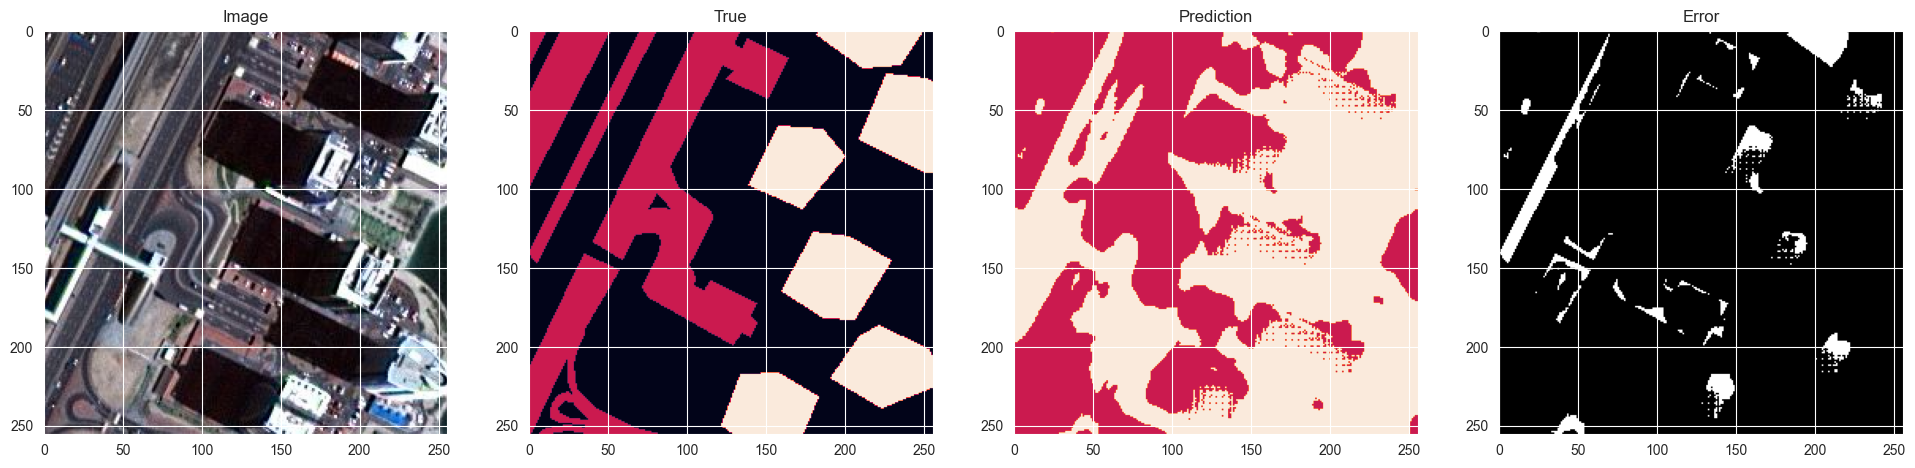

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


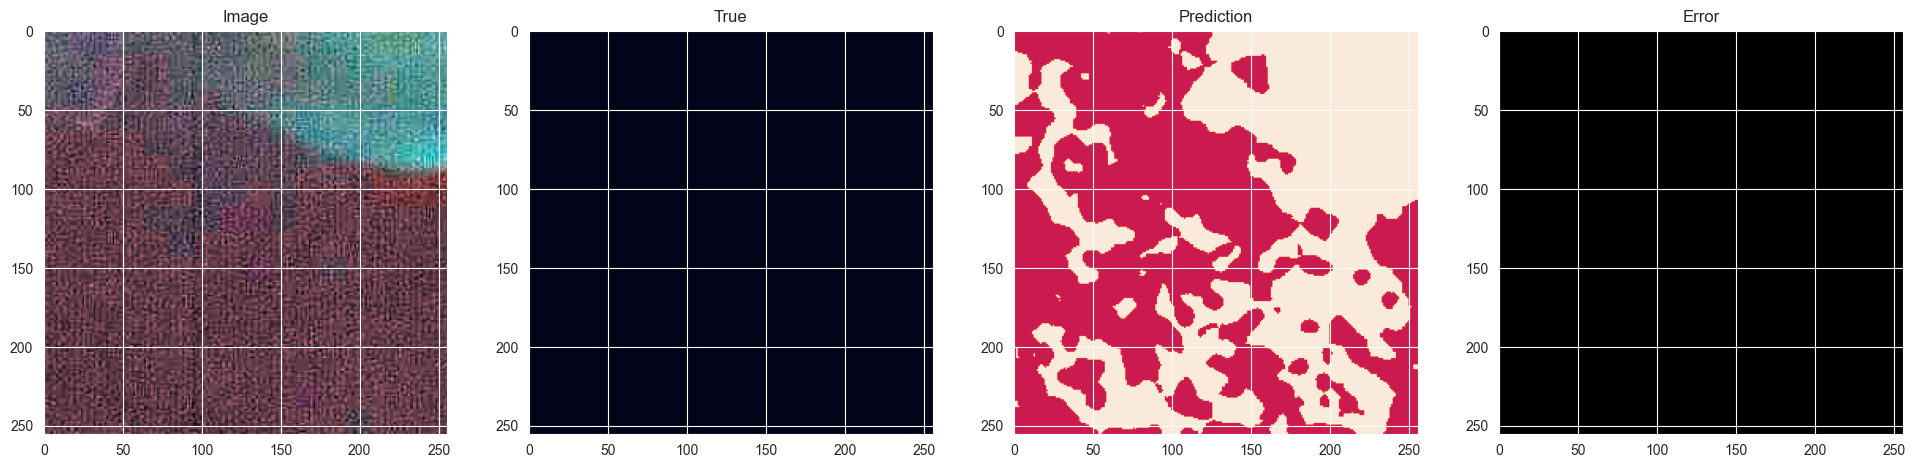

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


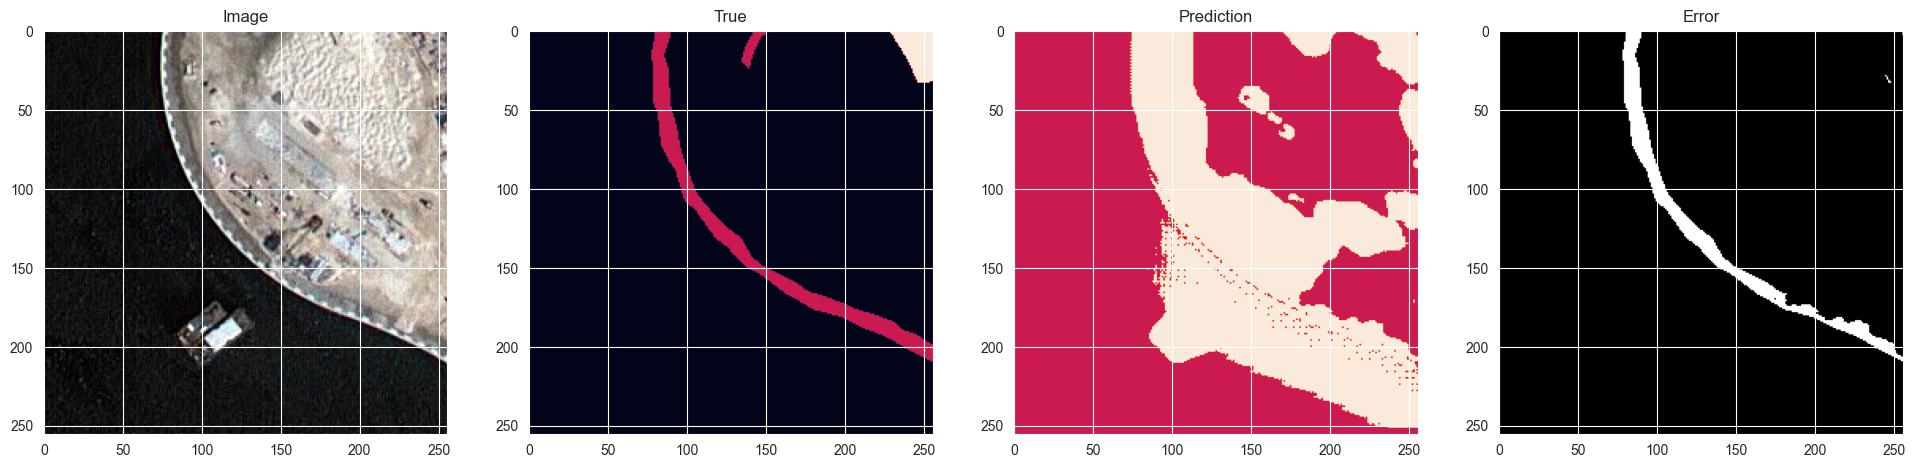

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


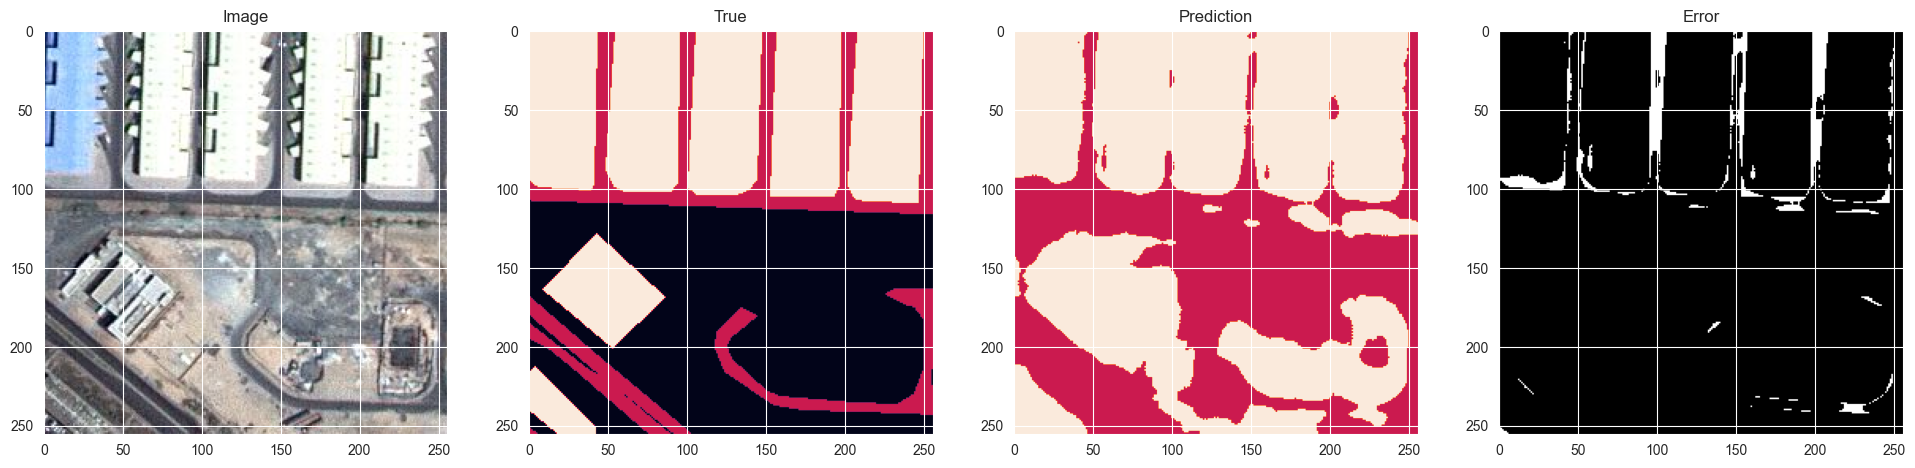

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


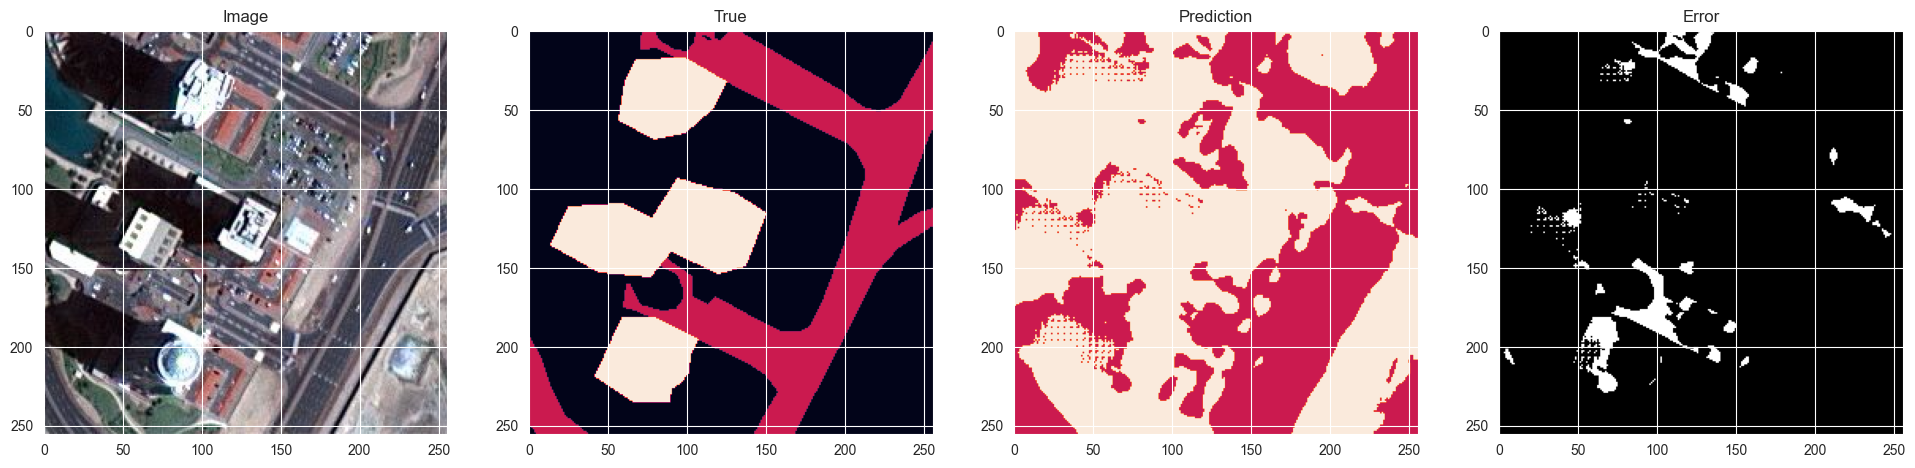

In [42]:
vmin = 0
vmax = 2

for i in range(5):
    
    image_number = random.randint(0, X_test.shape[0])
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)
    
    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1 # convert to 0-5 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()